In [1]:
import numpy as np
import awkward as ak 
import pandas as pd 
import time
import sys
import argparse
import json
import glob
from tqdm import tqdm
import uproot, pickle
import boost_histogram as bh
import os

########## Loop over the grid and evaulate ###############
#! Link for splines: https://github.com/nucleosynthesis/EFT-Fitter/blob/addgradients/tools/rbf_spline.py 
import sys
import numpy as np
import pandas as pd
import numpy.typing as npt

# -----------------
# Basis functions
# -----------------
class radialGauss():
    def __init__(self) -> None:
        return
    def evaluate(self, 
                 input: npt.NDArray[np.float32]) -> npt.NDArray[np.float32]:
        return np.exp(-input)
    def getDeltaPhi(self, 
                    input: npt.NDArray[np.float32]) -> npt.NDArray[np.float32]:
        return -self.evaluate(input)

class radialMultiQuad():
    def __init__(self) -> None:
        return
    def evaluate(self, 
                 input: npt.NDArray[np.float32]) -> npt.NDArray[np.float32]:
        return np.sqrt(1+input)
    def getDeltaPhi(self, 
                    input: npt.NDArray[np.float32]) -> npt.NDArray[np.float32]:
        return 1/(2*self.evaluate(input))
    
class radialInverseMultiQuad():
    def __init__(self) -> None:
        return
    def evaluate(self, 
                 input: npt.NDArray[np.float32]) -> npt.NDArray[np.float32]:
        return np.divide(1, np.sqrt(1+input))
    def getDeltaPhi(self, 
                    input: npt.NDArray[np.float32]) -> npt.NDArray[np.float32]:
        return -1/(2*np.power(1+input, 3/2))

class radialLinear():
    def __init__(self) -> None:
        return
    def evaluate(self, 
                 input: npt.NDArray[np.float32]) -> npt.NDArray[np.float32]:
        return np.sqrt(input)
    def getDeltaPhi(self, 
                    input: npt.NDArray[np.float32]) -> npt.NDArray[np.float32]:
        return 1/(2*self.evaluate(input))

class radialCubic():
    def __init__(self) -> None:
        return
    def evaluate(self, 
                 input: npt.NDArray[np.float32]) -> npt.NDArray[np.float32]:
        return np.power(input, 3/2)
    def getDeltaPhi(self, 
                    input: npt.NDArray[np.float32]) -> npt.NDArray[np.float32]:
        return 3*np.sqrt(input)/2
    
class radialQuintic():
    def __init__(self) -> None:
        return
    def evaluate(self, 
                 input: npt.NDArray[np.float32]) -> npt.NDArray[np.float32]:
        return np.power(input, 5/2)
    def getDeltaPhi(self, 
                    input: npt.NDArray[np.float32]) -> npt.NDArray[np.float32]:
        return 5*np.power(input, 3/2)/2

class radialThinPlate():
    def __init__(self) -> None:
        return
    def evaluate(self, 
                 input: npt.NDArray[np.float32]) -> npt.NDArray[np.float32]:
        return np.multiply(input, np.log(np.sqrt(input)))
    def getDeltaPhi(self, 
                    input: npt.NDArray[np.float32]) -> npt.NDArray[np.float32]:
        return (np.log(input)+1)/2
# -----------------

class rbf_spline:
    def __init__(self, ndim=1) -> None:
        self._ndim = ndim
        self._initialised = False
        self._radialFuncs = dict(
            [("gaussian", radialGauss),
             ("multiquadric", radialMultiQuad),
             ("inversemultiquadric", radialInverseMultiQuad),
             ("linear", radialLinear),
             ("cubic", radialCubic),
             ("quintic", radialQuintic),
             ("thinplate", radialThinPlate)
            ])

    def _initialise(self, input_data: pd.DataFrame, target: str, 
                    eps: float, rescaleAxis: bool) -> None:
        # Parse args
        self._input_data = input_data
        self._target_col = target
        self._input_pts = input_data.drop(target, axis="columns").to_numpy()
        self._eps = eps  
        self._rescaleAxis = rescaleAxis
        self._parameter_keys = list(input_data.columns)
        self._parameter_keys.remove(target)

        # Check number of basis points
        self._M = len(input_data)
        if self._M < 1 : 
            sys.exit("Error - At least one basis point is required")
        
        # Check dimensions
        if self._ndim!=len(self._parameter_keys): 
            sys.exit(f"Error - initialise given points with more dimensions " +
                     f"({len(self._parameter_keys)}) than ndim ({self._ndim})")

        # Get scalings by axis (column)
        self._axis_pts = np.power(self._M, 1./self._ndim)
        if self._rescaleAxis:
            self._scale = np.divide(self._axis_pts, 
                                    (np.max(self._input_pts, axis=0) -
                                     np.min(self._input_pts, axis=0)))
        else:
            self._scale = 1

        self.calculateWeights()

    def initialise(self, input_data: pd.DataFrame, target_col: str, 
                   radial_func: str="gaussian", eps: float=10.,
                   rescaleAxis: bool=True) -> None:
        # Get basis function and initialise
        try:
            self.radialFunc = self._radialFuncs[radial_func]()
        except KeyError:
            sys.exit(f"Error - function '{radial_func}' not in " +
                     f"'{list(self._radialFuncs.keys())}'")
        self._initialise(input_data, target_col, eps, rescaleAxis)
        
    def initialise_text(self, input_file: str, target_col, 
                        radial_func: str="gaussian", eps: float=10.,
                        rescaleAxis: bool=True) -> None:
        df = pd.read_csv(input_file, index_col=False, delimiter=' ')
        self.initialise(df,target_col,radial_func,eps,rescaleAxis)
        
    def diff(self, points1: npt.NDArray[np.float32],
             points2: npt.NDArray[np.float32]) -> npt.NDArray[np.float32]:
        # Get diff between two sets of points, pairwise
        v = np.multiply(self._scale, (points1[:, np.newaxis, :] - 
                                      points2[np.newaxis, :, :]))
        return v    
    
    def diff2(self, points1: npt.NDArray[np.float32], 
              points2: npt.NDArray[np.float32]) -> npt.NDArray[np.float32]:
        # Get squared diff between two sets of points, pairwise
        return np.power(self.diff(points1, points2), 2)
    
    def getDistFromSquare(self, point: npt.NDArray[np.float32]):
        # Get distance between a point and the basis points, per axis
        return self.diff2(point, self._input_pts)
    
    def getRadialArg(self, 
                     d2: npt.NDArray[np.float32]) -> npt.NDArray[np.float32]:
        # Get arg to pass to basis functions
        return np.divide(d2, self._eps*self._eps)

    def grad_r2(self, point) -> npt.NDArray[np.float32]:
        # Calculates grad(|r|^2)
        return (2*self.diff(point, self._input_pts)*self._scale/(self._eps*self._eps))

    def evaluate(self, point: pd.DataFrame) -> npt.NDArray[np.float32]:
        # Check input is okay (can be turned off for perfomance)
        if not self._initialised:
            print("Error - must first initialise spline with set of points " + 
                  "before calling evaluate()") 
            return np.array(np.nan)
        if not set(point.keys()) == set(self._parameter_keys): 
            print(f"Error - {point.keys()} must match {self._parameter_keys}")
            return np.array(np.nan)
        
        # Evaluate spline at point
        point_arr = point.to_numpy()
        radial_arg = self.getRadialArg(np.sum(self.getDistFromSquare(point_arr), axis=-1))
        vals = self.radialFunc.evaluate(radial_arg).flatten()
        
        # Get val and grads
        weighted_vals = self._weights * vals
        ret_val = np.sum(weighted_vals)
        
        return ret_val.astype(float)
    
    def evaluate_grad(self, point: pd.DataFrame) -> npt.NDArray[np.float32]:
        # Check input is okay (can be turned off for perfomance)
        if not self._initialised:
            print("Error - must first initialise spline with set of points " + 
                  "before calling evaluate()") 
            return np.array(np.nan)
        if not set(point.keys()) == set(self._parameter_keys): 
            print(f"Error - {point.keys()} must match {self._parameter_keys}")
            return np.array(np.nan)

        # Evaluate spline at point
        point_arr = point.to_numpy()
        radial_arg = self.getRadialArg(self.getDistFromSquare(point_arr))
        delta_phi = self.radialFunc.getDeltaPhi(radial_arg)
        grad_phi = np.linalg.norm(delta_phi, axis=-1)
        grads = self.grad_r2(point_arr) * grad_phi.reshape(1, self._M, 1) * np.sign(delta_phi)
        
        # Get val and grads
        weighted_grads = np.multiply(self._weights.reshape(1, self._M, 1), grads)
        ret_grad = np.sum(weighted_grads, axis=1)
        
        return ret_grad.astype(float)
        
    def calculateWeights(self) -> None: 
        # Solve interpolation matrix equation for weights
        inp = self._input_pts
        B = self._input_data[self._target_col].to_numpy()
        d2 = np.sum(self.diff2(inp, inp), axis=2)
        A = self.radialFunc.evaluate(self.getRadialArg(d2)) 
        np.fill_diagonal(A, 1)
    
        self._interp_mat = A
        self._inv_interp_mat = np.linalg.inv(A)
        self._weights = np.dot(self._inv_interp_mat, B)
        self._initialised = True
        
    def calculateLOOCV(self) -> float:
        # Get leave-one-out cross-validation error, implementing
        # https://doi.org/10.1023/A:1018975909870]
        if not self._initialised:
            print("Error - must first initialise spline with set of points " + 
                  "before calling evaluate()") 
            return np.nan
        
        cost_vec = self._weights / self._inv_interp_mat.diagonal()       
        return np.linalg.norm(cost_vec)



def findBestEpsilon(df, target, radial_func, eps_range, rescaleAxis):
    best_eps = 0
    best_loocv = np.inf
    spline = rbf_spline(3)
    print(f"Finding the best epsilon for the spline")
    for eps in eps_range:
        spline.initialise(df, target, radial_func=radial_func, eps=eps, rescaleAxis=rescaleAxis)
        loocv = spline.calculateLOOCV()
        if loocv < best_loocv:
            best_loocv = loocv
            best_eps = eps
        print(f"LOOCV: {loocv} for epsilon: {eps}")
    print(f"Best epsilon: {best_eps}")
    return best_eps

def init_splines(signal, weights, bins, epsilon=None, spline_type="cubic", fine_search=False):
    print("Initiating Splines")
    masses = np.unique(ak.to_numpy(signal[['mH', 'mA']])).view('<f4').reshape(-1, 2)
    mHs, mAs = masses[:,0], masses[:,1]

    print(f"Unique mHs = {np.unique(mHs)}")
    print(f"Unique mAs = {np.unique(mAs)}")

    print(f"Type = {type(mHs[0])}")

    mH_spline_input = []
    mA_spline_input = []
    pNNbins = []
    pNNoutputs = []

    for mH, mA in zip(mHs, mAs):
        # get signal for that mass 
        cut = (signal['mH'] == mH) & (signal['mA'] == mA)
        signal_mass = signal[cut]

        mass = f"mH{int(mH)}_mA{int(mA)}"
        pNNout, b = np.histogram(signal_mass[f'pnn_output_{mass}'],
                                bins=bins,
                                weights=weights[cut])

        if mass == "mH80_mA150":
            print(f"pNNout")
            for i, val in enumerate(pNNout):
                print(f"Bin {i: <3}: {val}")
        
        for i, (output, bin) in enumerate(zip(pNNout, bins[:-1])): # only need start edge of bin
            pNNbins.append(i)
            pNNoutputs.append(output)
            mH_spline_input.append(int(mH))
            mA_spline_input.append(int(mA - mH))

    data = {"mH" : mH_spline_input, "mA" : mA_spline_input, "pNNbin" : pNNbins,
            "pNN" : pNNoutputs}
    df = pd.DataFrame(data=data)

    if epsilon is not None:
        spline = rbf_spline(3)
        spline.initialise(df,'pNN', radial_func=spline_type, eps=epsilon, rescaleAxis=True)
        return spline, epsilon

    # Get the best value for eps
    eps_range = np.arange(0.1, 1.1, 0.1) # np.concatenate([np.arange(0.0001, 0.01, 0.0001) ,np.arange(0.01, 2.5, 0.01)], axis=0)
    # #eps_range = [0.5]
    # best_eps = 0
    # best_loocv = np.inf
    # spline = rbf_spline(3)
    # print(f"Finding the best epsilon for the spline")
    # for eps in eps_range:
    #     spline.initialise(df,'pNN', radial_func=spline_type, eps=eps, rescaleAxis=True)
    #     loocv = spline.calculateLOOCV()
    #     if loocv < best_loocv:
    #         best_loocv = loocv
    #         best_eps = eps
    #     print(f"LOOCV: {loocv} for epsilon: {eps}")
    # print(f"Best epsilon: {best_eps}")

    best_eps = findBestEpsilon(df, 'pNN', spline_type, eps_range, rescaleAxis=True)

    if fine_search:
        print(f"Doing a finer search for the best epislon")
        eps_range_fine = np.arange(best_eps - 0.1/2, best_eps + 0.1/2 + 0.01, 0.01)
        best_eps = findBestEpsilon(df, 'pNN', spline_type, eps_range_fine, rescaleAxis=True)

    spline = rbf_spline(3)
    spline.initialise(df,'pNN', radial_func=spline_type, eps=best_eps, rescaleAxis=True)

    return spline, best_eps


def interpolateSignal(spline, mH, mA, bins):
    interp_points = [spline.evaluate(pd.DataFrame(data={"mH" : [mH], "mA" : [mA], "pNNbin" : [bin]})) for bin in range(len(bins[:-1]))]

    # Make sure none are negative
    # if min(interp_points) < 0:
    #     print(f"WARNING: for mH{mH}_mA{mA}: Min histogram value < 0, hist = {interp_points}")
    interp_points = [max(x, 0) for x in interp_points]
    return interp_points


def combineChunk(event_list):
    chunk_size = 10
    num_chunks = len(event_list) // chunk_size

    if num_chunks == 0:
        evs = ak.merge_option_of_records(ak.concatenate(event_list))
        return evs

    events = []
    for i in range(num_chunks + 1):
        evs = event_list[i * chunk_size:(i + 1) * chunk_size]
        if len(evs) == 0:
            continue
        evs = ak.merge_option_of_records(ak.concatenate(evs))
        events.append(evs)
    
    return events

def combineInChunks(event_list):
    print("Inside combine in chunks")
    combined = False
    while not combined:
        event_list = combineChunk(event_list)
        if isinstance(event_list, ak.Array):
            print("Here")
            combined = True

    return event_list


def rescaleWeightsToCorrectLumi(events, ecom):
    if ecom == 240:
        scale = 10800000 / 5000000
    elif ecom == 365:
        scale = 3000000 / 5000000
    else:
        raise ValueError("Invalid ecom")

    events['weight_nominal_scaled'] = events['weight_nominal_scaled'] * scale

    return events

def convertToBoostHistogram(hist, sumw2, bins):
    root_hist = bh.Histogram(bh.axis.Variable(bins), 
                            storage=bh.storage.Weight())

    root_hist[...] = np.stack([hist, sumw2], axis=-1)

    return root_hist



train_direc = "/vols/cms/emc21/FCC/FCC-Study/runs/e240_full_run/run25"
output_direc = "/vols/cms/emc21/FCC/FCC-Study/runs/e240_full_run/run25/combine_grid_space_2.5"
ecom = 240

# Load in the mass scaler
mass_scaler = pickle.load(open(f"{train_direc}/mass_scaler.pkl", "rb"))

# Load in the mass scan
mass_pairs = np.loadtxt(f"{output_direc}/mass_scan.txt")

bins = np.linspace(0.9, 1, 25)

# Load the signal and weights
branches = ['n_muons', 'n_electrons', 'pnn_output_*', 'weight_nominal_scaled', 'mH', 'mA']

signal = []
#test_files = glob.glob(f"data/test/awkward/*.parquet")
sig_files = glob.glob(f"{train_direc}/data/test/awkward/mH*.parquet")
for file in tqdm(sig_files[:20]):
    # Only want to read in the files that have mH + mA < ecom
    file_name = file.split("/")[-1]
    mH = int(file_name.split("mH")[1].split("_")[0])
    mA = int(file_name.split("mA")[1].split(".")[0])
    if mH + mA >= ecom:
        print(f"Skipping {file_name}")
        continue
    signal.append(ak.from_parquet(file, columns=branches))

signal = combineInChunks(signal)
signal = rescaleWeightsToCorrectLumi(signal, ecom)


  0%|          | 0/20 [00:00<?, ?it/s]

Skipping mH90_mA182.parquet


 25%|██▌       | 5/20 [00:00<00:01,  8.04it/s]

Skipping mH105_mA155.parquet
Skipping mH110_mA150.parquet


 35%|███▌      | 7/20 [00:00<00:01,  8.85it/s]

Skipping mH80_mA240.parquet


 55%|█████▌    | 11/20 [00:01<00:01,  8.92it/s]

Skipping mH105_mA175.parquet
Skipping mH75_mA195.parquet


 95%|█████████▌| 19/20 [00:01<00:00, 16.00it/s]

Skipping mH105_mA215.parquet
Skipping mH60_mA220.parquet
Skipping mH50_mA250.parquet
Skipping mH110_mA290.parquet
Skipping mH100_mA180.parquet


100%|██████████| 20/20 [00:01<00:00, 10.67it/s]


Inside combine in chunks
Here


In [2]:

# Change the mass to the unscaled mass
masses = ak.to_numpy(signal[['mH', 'mA']]).view('<f4').reshape(-1, 2)
masses

array([[0.08333331, 0.3148148 ],
       [0.08333331, 0.3148148 ],
       [0.08333331, 0.3148148 ],
       ...,
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ]], dtype=float32)

In [3]:
unscaled_masses = mass_scaler.inverse_transform(masses)
signal['mH'] = np.round(unscaled_masses[:, 0])
signal['mA'] = np.round(unscaled_masses[:, 1])


In [4]:
np.round(unscaled_masses[:, 0])

array([55., 55., 55., ..., 50., 50., 50.], dtype=float32)

In [5]:
process = "Electron"
events_proc = signal[signal[f'n_{process.lower()}s'] == 2]

weights_array = events_proc.weight_nominal_scaled
# initiate the splines
spline, best_eps = init_splines(events_proc, weights = weights_array, bins = bins, fine_search = True)

Initiating Splines
Unique mHs = [50. 55. 65. 75. 85. 90.]
Unique mAs = [ 60. 105. 120. 130. 135. 145. 147.]
Type = <class 'numpy.float32'>
Finding the best epsilon for the spline
LOOCV: 92862.3308535726 for epsilon: 0.1


LOOCV: 94113.6337654012 for epsilon: 0.2
LOOCV: 95761.19941794098 for epsilon: 0.30000000000000004
LOOCV: 97362.97077975296 for epsilon: 0.4
LOOCV: 98824.14931444098 for epsilon: 0.5
LOOCV: 100070.6767324694 for epsilon: 0.6
LOOCV: 101074.2591584649 for epsilon: 0.7000000000000001
LOOCV: 101849.83476899254 for epsilon: 0.8
LOOCV: 102430.14620946831 for epsilon: 0.9
LOOCV: 102850.4805437419 for epsilon: 1.0
Best epsilon: 0.1
Doing a finer search for the best epislon
Finding the best epsilon for the spline
LOOCV: 92626.36947048464 for epsilon: 0.05
LOOCV: 92652.39916315753 for epsilon: 0.060000000000000005
LOOCV: 92688.10472100564 for epsilon: 0.07
LOOCV: 92734.54467688072 for epsilon: 0.08000000000000002
LOOCV: 92792.47754158209 for epsilon: 0.09000000000000001
LOOCV: 92862.3308535726 for epsilon: 0.1
LOOCV: 92944.19299020794 for epsilon: 0.11000000000000001
LOOCV: 93037.82884235185 for epsilon: 0.12000000000000001
LOOCV: 93142.71648940102 for epsilon: 0.13
LOOCV: 93258.09905988799 for 

In [6]:

for process in ['Electron', 'Muon']:

    histogram_dict = {}

    events_proc = signal[signal[f'n_{process.lower()}s'] == 2]

    weights_array = events_proc.weight_nominal_scaled
    # initiate the splines
    spline, best_eps = init_splines(events_proc, weights = weights_array, bins = bins, fine_search = True)

    
    # Now save straight to root files
    #with uproot.recreate(f"{output_direc}/combine/{year}/OF_histograms/{mass}_OF_CR_{year}_hists.root") as f:

    for mH, mA in tqdm(mass_pairs):
        interp_signal = interpolateSignal(spline, mH, mA - mH, bins = bins)

        if (mH == 80) & (mA == 150):
            print(f"interp_signal")
            for i, val in enumerate(interp_signal):
                print(f"Bin {i: <3}: {val}")

        # Now add to histogram dict
        if f"mH{int(mH)}_mA{int(mA)}" in histogram_dict:
            histogram_dict[f"mH{int(mH)}_mA{int(mA)}"][f"{process};idm;mH{int(mH)}_mA{int(mA)}"] = interp_signal
        else:
            histogram_dict[f"mH{int(mH)}_mA{int(mA)}"] = {f"{process};idm;mH{int(mH)}_mA{int(mA)}" : interp_signal}


# Now that I have the histogram dict, I can save these directly to signal root files
# Convert all the histograms to boost histograms

for mass_point, histogram_dict in histogram_dict.items():
    print(f"Saving for {mass_point}")
    root_histograms = {}
    for key, histogram in histogram_dict.items():
        PROCESS, proc_name, mass = key.split(";")
        root_histogram = convertToBoostHistogram(histogram, np.zeros_like(histogram), bins)
        root_histograms[f"{proc_name}"] = root_histogram

    # Now save all of the histograms
    # make the directory
    save_direc = f"{output_direc}/combine/{mass_point}"
    os.makedirs(save_direc, exist_ok=True)

    save_loc = f"{save_direc}/{mass_point}_signal_{process}_hists.root"

    with uproot.recreate(save_loc) as f:
        for key, hist in root_histograms.items():
            f[key] = hist


Initiating Splines
Unique mHs = [50. 55. 65. 75. 85. 90.]
Unique mAs = [ 60. 105. 120. 130. 135. 145. 147.]
Type = <class 'numpy.float32'>
Finding the best epsilon for the spline
LOOCV: 92862.3308535726 for epsilon: 0.1
LOOCV: 94113.6337654012 for epsilon: 0.2
LOOCV: 95761.19941794098 for epsilon: 0.30000000000000004
LOOCV: 97362.97077975296 for epsilon: 0.4
LOOCV: 98824.14931444098 for epsilon: 0.5
LOOCV: 100070.6767324694 for epsilon: 0.6
LOOCV: 101074.2591584649 for epsilon: 0.7000000000000001
LOOCV: 101849.83476899254 for epsilon: 0.8
LOOCV: 102430.14620946831 for epsilon: 0.9
LOOCV: 102850.4805437419 for epsilon: 1.0
Best epsilon: 0.1
Doing a finer search for the best epislon
Finding the best epsilon for the spline
LOOCV: 92626.36947048464 for epsilon: 0.05
LOOCV: 92652.39916315753 for epsilon: 0.060000000000000005
LOOCV: 92688.10472100564 for epsilon: 0.07
LOOCV: 92734.54467688072 for epsilon: 0.08000000000000002
LOOCV: 92792.47754158209 for epsilon: 0.09000000000000001
LOOCV: 92

 77%|███████▋  | 527/684 [00:03<00:01, 150.52it/s]

interp_signal
Bin 0  : 0
Bin 1  : 0
Bin 2  : 0
Bin 3  : 0
Bin 4  : 0
Bin 5  : 0
Bin 6  : 0
Bin 7  : 0
Bin 8  : 0
Bin 9  : 0
Bin 10 : 0
Bin 11 : 0
Bin 12 : 0
Bin 13 : 0
Bin 14 : 0
Bin 15 : 0
Bin 16 : 0
Bin 17 : 0
Bin 18 : 0
Bin 19 : 0
Bin 20 : 0
Bin 21 : 0
Bin 22 : 0
Bin 23 : 0


100%|██████████| 684/684 [00:04<00:00, 148.35it/s]


Initiating Splines
Unique mHs = [50. 55. 65. 75. 85. 90.]
Unique mAs = [ 60. 105. 120. 130. 135. 145. 147.]
Type = <class 'numpy.float32'>
Finding the best epsilon for the spline
LOOCV: 74076.76535505887 for epsilon: 0.1
LOOCV: 75577.11789636666 for epsilon: 0.2
LOOCV: 77569.96388872978 for epsilon: 0.30000000000000004
LOOCV: 79514.18839053887 for epsilon: 0.4
LOOCV: 81279.39376656034 for epsilon: 0.5
LOOCV: 82799.01171203612 for epsilon: 0.6
LOOCV: 84058.99047795346 for epsilon: 0.7000000000000001
LOOCV: 85082.70212689268 for epsilon: 0.8
LOOCV: 85906.44515931186 for epsilon: 0.9
LOOCV: 86566.50592518762 for epsilon: 1.0
Best epsilon: 0.1
Doing a finer search for the best epislon
Finding the best epsilon for the spline
LOOCV: 73793.3913843471 for epsilon: 0.05
LOOCV: 73824.67989505091 for epsilon: 0.060000000000000005
LOOCV: 73867.58631058272 for epsilon: 0.07
LOOCV: 73923.37123266271 for epsilon: 0.08000000000000002
LOOCV: 73992.93163244086 for epsilon: 0.09000000000000001
LOOCV: 740

 78%|███████▊  | 531/684 [00:03<00:00, 154.31it/s]

interp_signal
Bin 0  : 0
Bin 1  : 0
Bin 2  : 0
Bin 3  : 0
Bin 4  : 0
Bin 5  : 0
Bin 6  : 0
Bin 7  : 0
Bin 8  : 0
Bin 9  : 0
Bin 10 : 0
Bin 11 : 0
Bin 12 : 0
Bin 13 : 0
Bin 14 : 0
Bin 15 : 143.23742994316854
Bin 16 : 284.89974497351795
Bin 17 : 371.9108550239471
Bin 18 : 378.0243654541846
Bin 19 : 282.2975364586164
Bin 20 : 82.78034870774718
Bin 21 : 0
Bin 22 : 0
Bin 23 : 0


100%|██████████| 684/684 [00:04<00:00, 145.88it/s]


Saving for mH50_mA60
Saving for mH50_mA62
Saving for mH50_mA65
Saving for mH50_mA67
Saving for mH50_mA70
Saving for mH50_mA72
Saving for mH50_mA75
Saving for mH50_mA77
Saving for mH50_mA80
Saving for mH50_mA82
Saving for mH50_mA85
Saving for mH50_mA87
Saving for mH50_mA90
Saving for mH50_mA92
Saving for mH50_mA95
Saving for mH50_mA97
Saving for mH50_mA100
Saving for mH50_mA102
Saving for mH50_mA105
Saving for mH50_mA107
Saving for mH50_mA110
Saving for mH50_mA112
Saving for mH50_mA115
Saving for mH50_mA117
Saving for mH50_mA120
Saving for mH50_mA122
Saving for mH50_mA125
Saving for mH50_mA127
Saving for mH50_mA130
Saving for mH50_mA132
Saving for mH50_mA135
Saving for mH50_mA137
Saving for mH50_mA140
Saving for mH50_mA142
Saving for mH50_mA145
Saving for mH50_mA147
Saving for mH50_mA150
Saving for mH50_mA152
Saving for mH50_mA155
Saving for mH50_mA157
Saving for mH50_mA160
Saving for mH50_mA162
Saving for mH50_mA165
Saving for mH50_mA167
Saving for mH50_mA170
Saving for mH52_mA62
Savin

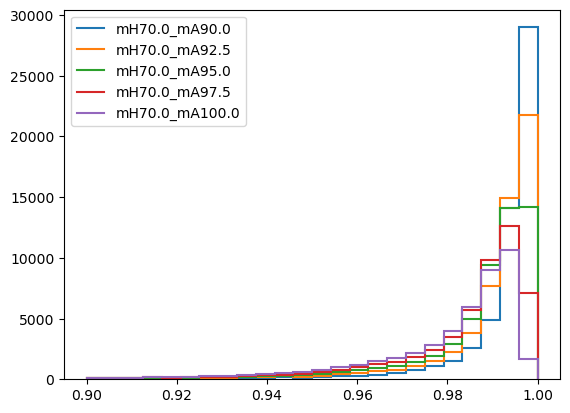

In [18]:
import matplotlib.pyplot as plt
import mplhep as hep
files = [
    "/vols/cms/emc21/FCC/FCC-Study/runs/e240_full_run/run25/combine_grid_space_2.5/combine/mH70.0_mA90.0/mH70.0_mA90.0_signal_Muon_hists.root", 
    "/vols/cms/emc21/FCC/FCC-Study/runs/e240_full_run/run25/combine_grid_space_2.5/combine/mH70.0_mA92.5/mH70.0_mA92.5_signal_Muon_hists.root",
    "/vols/cms/emc21/FCC/FCC-Study/runs/e240_full_run/run25/combine_grid_space_2.5/combine/mH70.0_mA95.0/mH70.0_mA95.0_signal_Muon_hists.root",
    "/vols/cms/emc21/FCC/FCC-Study/runs/e240_full_run/run25/combine_grid_space_2.5/combine/mH70.0_mA97.5/mH70.0_mA97.5_signal_Muon_hists.root",
    "/vols/cms/emc21/FCC/FCC-Study/runs/e240_full_run/run25/combine_grid_space_2.5/combine/mH70.0_mA100.0/mH70.0_mA100.0_signal_Muon_hists.root"    
]
bins = np.linspace(0.9, 1, 25)
for file in files:
    f = uproot.open(file)
    # print(f.keys())
    # for key in f.keys():
    #     print(f[key].values())

    hist = f['idm'].values()

    filename = file.split("/")[-1]
    name = filename.split("_signal")[0]


    hep.histplot(hist, bins = bins, label = name, histtype = "step")

plt.legend()